# Bike Sharing Demand Challenge with Dask

##### Camille Chauliac - camille.chauliac@student.ie.edu
##### MBD O-2

This project is about rewriting our Bike Sharing demand assignment of the Python course. 

On Kaggle's website (https://www.kaggle.com/marklvl/bike-sharing-dataset/home), two datasets (hourly and daily data from 2011-2012) are provided with information about the Bike Sharing service in Washington D.C.


## 1) Importing libraries and datasets

As in every machine learning problem, the notebook has to be set up in a correct way to be able to start. 
The most important step in the beginning is to make sure you've imported all necessary libraries you'll need throughout the process. Then ofcourse, you'll also need to load your datasets to work on.

In [46]:
import dask
import dask.dataframe as dd
import dask.array as da

from dask_ml.preprocessing import DummyEncoder, Categorizer
from dask_ml.linear_model import LinearRegression
from dask_ml.linear_model import LogisticRegression
from dask.distributed import Client

from sklearn import linear_model

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import r2_score
from sklearn.externals import joblib
from sklearn.externals.joblib import parallel_backend

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from dask_ml.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestRegressor

In [47]:
df_day = dd.read_csv('/Users/camillechauliac/Desktop/Python-Final-Project/Bike-Sharing-Dataset/day.csv')
df_hour = dd.read_csv('/Users/camillechauliac/Desktop/Python-Final-Project/Bike-Sharing-Dataset/hour.csv')

In [4]:
df_day.head()

instant      dteday  season  yr  mnth  holiday  weekday  workingday  \
0        1  2011-01-01       1   0     1        0        6           0   
1        2  2011-01-02       1   0     1        0        0           0   
2        3  2011-01-03       1   0     1        0        1           1   
3        4  2011-01-04       1   0     1        0        2           1   
4        5  2011-01-05       1   0     1        0        3           1   

   weathersit      temp     atemp       hum  windspeed  casual  registered  \
0           2  0.344167  0.363625  0.805833   0.160446     331         654   
1           2  0.363478  0.353739  0.696087   0.248539     131         670   
2           1  0.196364  0.189405  0.437273   0.248309     120        1229   
3           1  0.200000  0.212122  0.590435   0.160296     108        1454   
4           1  0.226957  0.229270  0.436957   0.186900      82        1518   

    cnt  
0   985  
1   801  
2  1349  
3  1562  
4  1600

In [5]:
df_hour.head()

instant      dteday  season  yr  mnth  hr  holiday  weekday  workingday  \
0        1  2011-01-01       1   0     1   0        0        6           0   
1        2  2011-01-01       1   0     1   1        0        6           0   
2        3  2011-01-01       1   0     1   2        0        6           0   
3        4  2011-01-01       1   0     1   3        0        6           0   
4        5  2011-01-01       1   0     1   4        0        6           0   

   weathersit  temp   atemp   hum  windspeed  casual  registered  cnt  
0           1  0.24  0.2879  0.81        0.0       3          13   16  
1           1  0.22  0.2727  0.80        0.0       8          32   40  
2           1  0.22  0.2727  0.80        0.0       5          27   32  
3           1  0.24  0.2879  0.75        0.0       3          10   13  
4           1  0.24  0.2879  0.75        0.0       0           1    1

In [6]:
df_hour.info()
df_hour.dtypes

<class 'dask.dataframe.core.DataFrame'>
Columns: 17 entries, instant to cnt
dtypes: object(1), float64(4), int64(12)

instant         int64
dteday         object
season          int64
yr              int64
mnth            int64
hr              int64
holiday         int64
weekday         int64
workingday      int64
weathersit      int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
casual          int64
registered      int64
cnt             int64
dtype: object

In [7]:
df_day.info()
df_day.dtypes

<class 'dask.dataframe.core.DataFrame'>
Columns: 16 entries, instant to cnt
dtypes: object(1), float64(4), int64(11)

instant         int64
dteday         object
season          int64
yr              int64
mnth            int64
holiday         int64
weekday         int64
workingday      int64
weathersit      int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
casual          int64
registered      int64
cnt             int64
dtype: object

We can see that both datasets are pretty similar, but that the hourly dataset provides an extra variable hour which makes the dataset more complete. Therefore, the choice is made to only continue with the hourly dataset from now on. 

### Change of dtypes

As some of the variables in the df_hour dataset have weird datatypes, we start off with changing the respective datatypes of season, year, month, holiday, weekday, workingday and weathersit. Those will be changed into categorical variables.

In [48]:
df_hour[['season']]= df_hour[['season']].astype('category')
df_hour[['yr']]= df_hour[['yr']].astype('category')
df_hour[['mnth']]= df_hour[['mnth']].astype('category')
df_hour[['hr']]= df_hour[['hr']].astype('category')
df_hour[['holiday']]= df_hour[['holiday']].astype('category')
df_hour[['weekday']]= df_hour[['weekday']].astype('category')
df_hour[['workingday']]= df_hour[['workingday']].astype('category')
df_hour[['weathersit']]= df_hour[['weathersit']].astype('category')

As the dteday is of type object, we will also change this into a date type.

In [49]:
df_hour["dteday"] = dd.to_datetime(df_hour.dteday)

In [10]:
df_hour.dtypes

instant                int64
dteday        datetime64[ns]
season              category
yr                  category
mnth                category
hr                  category
holiday             category
weekday             category
workingday          category
weathersit          category
temp                 float64
atemp                float64
hum                  float64
windspeed            float64
casual                 int64
registered             int64
cnt                    int64
dtype: object

### Dropping unnecassary columns

Once we are satisfied with the datatypes of each variable, it is time to look at the columns in itself to be sure we are going as efficient as possbile about it.

In [50]:
df_hour = df_hour.drop(["casual", "registered"], axis=1)

In [12]:
df_hour.head()

instant     dteday season yr mnth hr holiday weekday workingday weathersit  \
0        1 2011-01-01      1  0    1  0       0       6          0          1   
1        2 2011-01-01      1  0    1  1       0       6          0          1   
2        3 2011-01-01      1  0    1  2       0       6          0          1   
3        4 2011-01-01      1  0    1  3       0       6          0          1   
4        5 2011-01-01      1  0    1  4       0       6          0          1   

   temp   atemp   hum  windspeed  cnt  
0  0.24  0.2879  0.81        0.0   16  
1  0.22  0.2727  0.80        0.0   40  
2  0.22  0.2727  0.80        0.0   32  
3  0.24  0.2879  0.75        0.0   13  
4  0.24  0.2879  0.75        0.0    1

In [13]:
df_hour.season.unique().compute()

0    1
1    2
2    3
3    4
Name: season, dtype: category
Categories (4, int64): [1, 2, 3, 4]

In [14]:
df_hour.weathersit.value_counts().compute()

1    11413
2     4544
3     1419
4        3
Name: weathersit, dtype: int64

### Checking for null values in the dataset

In [16]:
df_hour.isna().sum().compute()

instant       0
dteday        0
season        0
yr            0
mnth          0
hr            0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
cnt           0
dtype: int64

We can see that we don't have to deal with any null values for this dataset.

## Some visualisations

### Monthly distribution of bikes

[Text(0.5, 1.0, 'Monthly distribution of bikes')]

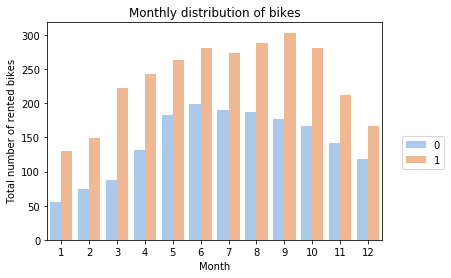

In [17]:
fig, ax = plt.subplots()
sns.barplot(
    "mnth",
    "cnt",
    hue="yr",
    data=df_hour[["mnth", "cnt", "yr"]].compute(),
    palette="pastel",
    ci=None,
)
plt.legend(loc="upper right", bbox_to_anchor=(1.2, 0.5))
plt.xlabel("Month")
plt.ylabel("Total number of rented bikes")
ax.set(title="Monthly distribution of bikes")

### Total count of rented bikes per month

In [18]:
import seaborn as sns
sns.set_style('darkgrid')
sns.set_context('paper')
params = {'legend.fontsize': 'large',
          'figure.figsize': (25, 10),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'large',
          'ytick.labelsize':'large'}

plt.rcParams.update(params)

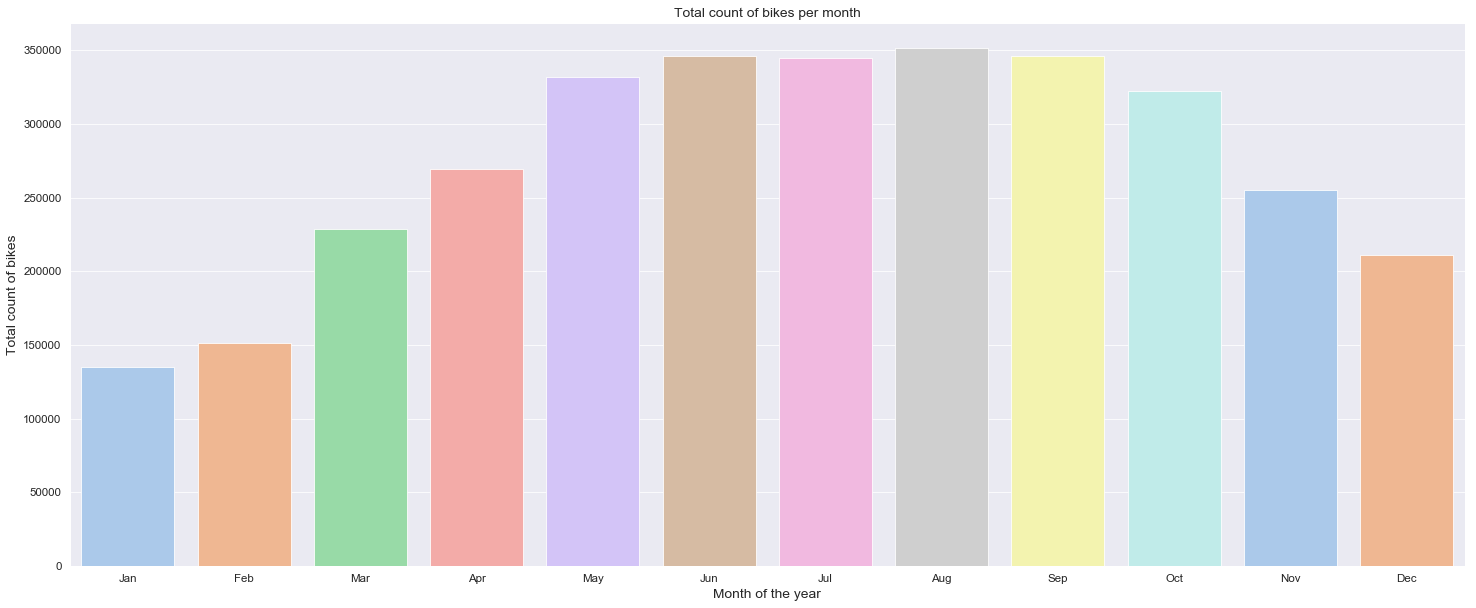

In [19]:
fig, ax = plt.subplots()
monthly_plot = sns.barplot(data = df_hour[['mnth',
                                        'cnt']].compute(),
                           x = 'mnth',
                           y = 'cnt',
                           ci = None,
                           palette='pastel',
                           estimator = sum)
ax.set(xlabel = 'Month of the year', ylabel = 'Total count of bikes', title = 'Total count of bikes per month')
ax.set_xticklabels(['Jan','Feb','Mar','Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()

### Hourly distribution of the rented bikes per month

/Users/camillechauliac/anaconda/envs/Python3.7/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


[Text(0.5, 1.0, 'Hourly distribution bike renting by years')]

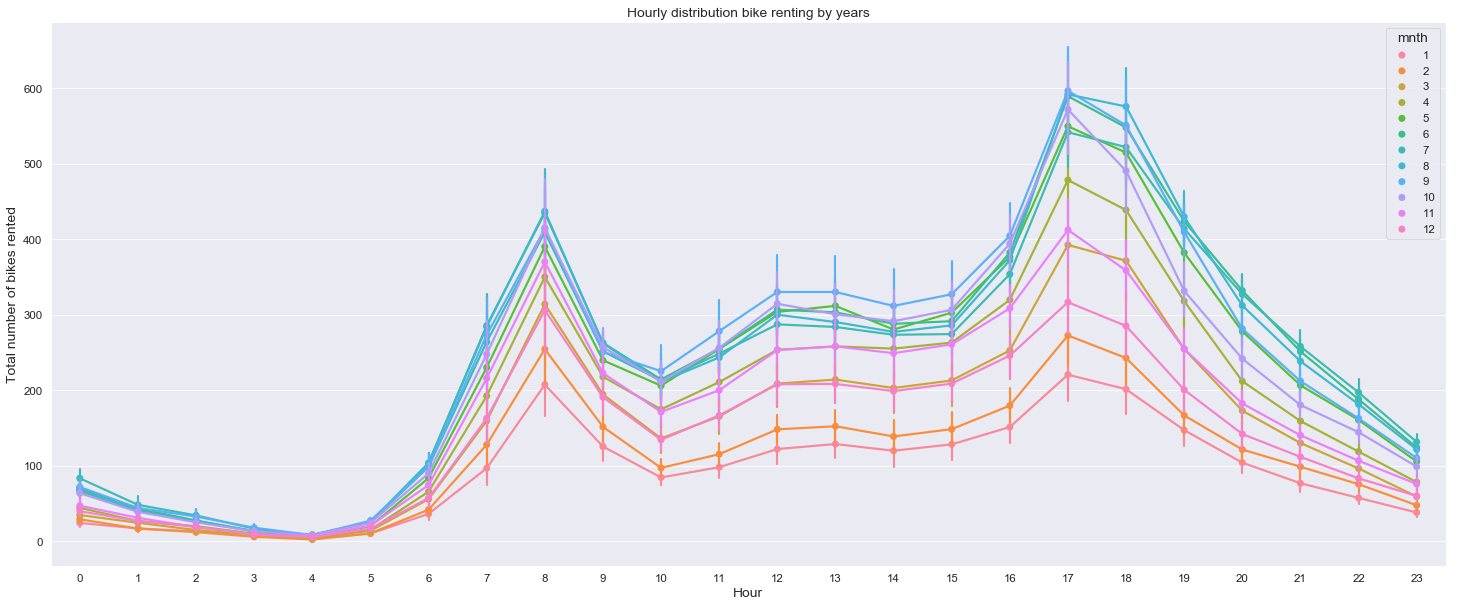

In [21]:
fig, ax = plt.subplots()
sns.pointplot(
    data=df_hour[["hr", "cnt", "mnth"]].compute(),
    x="hr",
    y="cnt",
    hue="mnth",
    ax=ax,
)
plt.xlabel("Hour")
plt.ylabel("Total number of bikes rented")
ax.set(title="Hourly distribution bike renting by years")

In summer months, where temperature more logically are higher, the overall rented bikes is clearly higher. The blueish colors represent months May, June, July, August, September and October.

## Correlation Matrix

To see which non-categorical features are very correlated, we design a correlation matrix. 
This matrix will tell us which ones are too heavily correlated which impacts models in a negative way and causes overfitting. After checking for the correlation, we'll have to decide to drop some of the variables. 

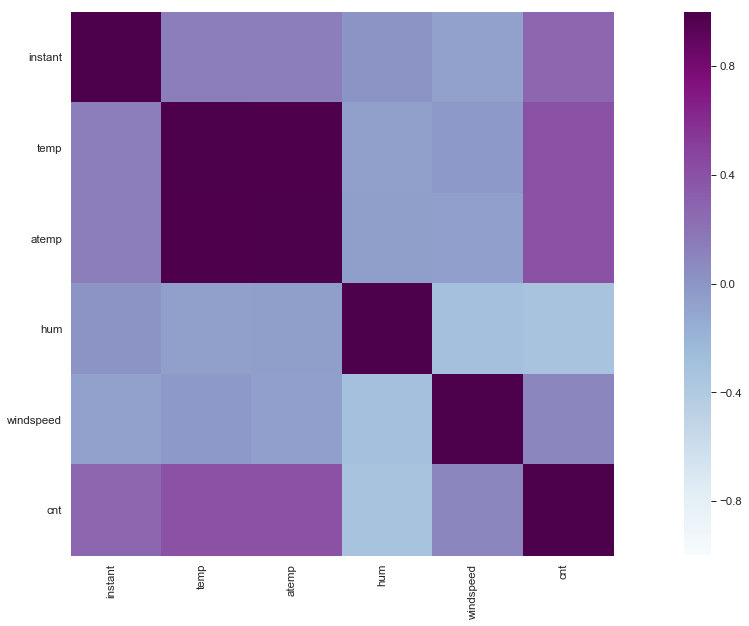

In [206]:
names = ['instant','temp','atemp','hum','windspeed','cnt']
ax = sns.heatmap(
    df_hour.corr(), 
    vmin=-1, vmax=1, center=0,
    cmap="BuPu",
    square=True
)
ax.set_xticklabels(names,
    rotation=90,
    horizontalalignment='right'
)

ax.set_yticklabels(names,
    rotation=0
);

There is a clear correlation, very high correlation, between temp and atemp. We could have seen this coming, but it is always better to be safe (through a correlation matrix) than sorry.

In [51]:
# Remove atemp
df_hour = df_hour.drop("atemp", 1)

## Creating dummies for the categorical variables

In [52]:
dummy_maker = DummyEncoder()
df_hour_dummified = dummy_maker.fit_transform(df_hour.categorize())

df_hour_dummified.head()

instant     dteday  temp   hum  windspeed  cnt  season_1  season_2  \
0        1 2011-01-01  0.24  0.81        0.0   16         1         0   
1        2 2011-01-01  0.22  0.80        0.0   40         1         0   
2        3 2011-01-01  0.22  0.80        0.0   32         1         0   
3        4 2011-01-01  0.24  0.75        0.0   13         1         0   
4        5 2011-01-01  0.24  0.75        0.0    1         1         0   

   season_3  season_4  ...  weekday_3  weekday_4  weekday_5  weekday_6  \
0         0         0  ...          0          0          0          1   
1         0         0  ...          0          0          0          1   
2         0         0  ...          0          0          0          1   
3         0         0  ...          0          0          0          1   
4         0         0  ...          0          0          0          1   

   workingday_0  workingday_1  weathersit_1  weathersit_2  weathersit_3  \
0             1             0             1             0             0   
1             1             0             1             0             0   
2             1             0             1             0             0   
3             1             0             1             0             0   
4             1             0             1             0             0   

   weathersit_4  
0             0  
1             0  
2             0  
3             0  
4             0  

[5 rows x 63 columns]

## Splitting the dataset in a train and test set.

Those two seperated sets will be needed to implement in the models in order to train and test them. The test set is the last quarter of the year 2012, all the other remaining data will be used to train the models. 

In [53]:
X = df_hour_dummified.loc[:, df_hour_dummified.columns != 'cnt']
y = df_hour_dummified.loc[:, ['instant','cnt']]

In [54]:
X_train = X.loc[(X.instant <= 15211)].drop(['dteday', 'instant'], axis=1)
y_train = y.loc[(y.instant <= 15211)].drop('instant', axis=1)
X_test = X.loc[(X.instant > 15211)].drop(['dteday', 'instant'], axis=1)
y_test = y.loc[(y.instant > 15211)].drop('instant', axis=1)

In [55]:
X_train.values.shape

(nan, 60)

In [56]:
y_train.values.shape

(nan, 1)

In [66]:
X_train_arr = X_train.to_dask_array(lengths=True)
X_test_arr = X_test.to_dask_array(lengths=True)
y_train_arr = y_train.to_dask_array(lengths=True)
y_test_arr = y_test.to_dask_array(lengths=True)

In [69]:
X_train_final.values.shape

(nan, 61)

In [74]:
y_train_final.values.shape

(nan,)

In [75]:
X_test_final.values.shape

(nan, 61)

In [76]:
y_test_final.values.shape

(nan,)

In [78]:
X_test.values.shape

(nan, 60)

In [80]:
y_test.values.shape

(nan, 1)

# Modelling

## Model 1:          Linear Regression

In [29]:
l_model = LinearRegression()
l_model.fit(X_train.values, y_train.values)

/Users/camillechauliac/anaconda/envs/Python3.7/lib/python3.7/site-packages/dask/blockwise.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  contains = index in indices
/Users/camillechauliac/anaconda/envs/Python3.7/lib/python3.7/site-packages/dask/blockwise.py:595: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  sub[blockwise_token(i)] = blockwise_token(indices.index(index))


LinearRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
         intercept_scaling=1.0, max_iter=100, multi_class='ovr', n_jobs=1,
         penalty='l2', random_state=None, solver='admm',
         solver_kwargs=None, tol=0.0001, verbose=0, warm_start=False)

In [30]:
linear_prediction = l_model.predict(X_test.values)

In [31]:
print(r2_score(y_test.values.compute(), linear_prediction.compute()))

/Users/camillechauliac/anaconda/envs/Python3.7/lib/python3.7/site-packages/dask/blockwise.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  contains = index in indices
/Users/camillechauliac/anaconda/envs/Python3.7/lib/python3.7/site-packages/dask/blockwise.py:595: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  sub[blockwise_token(i)] = blockwise_token(indices.index(index))


0.6354059045420941


Not a really high score, so let's try with other models now to run deeper.

## Model 2: RandomForest

In [32]:
# Create a client
Client_Dask = Client()
Client_Dask

<Client: scheduler='tcp://127.0.0.1:62019' processes=4 cores=4>

In [41]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()

In [42]:
with parallel_backend('dask'):
    rf.fit(X_train.values, y_train.values)
    rf_pref=rf.predict(X_test.values)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend DaskDistributedBackend with 4 concurrent workers.
tornado.application - ERROR - Exception in callback functools.partial(<bound method IOLoop._discard_future_result of <zmq.eventloop.ioloop.ZMQIOLoop object at 0x1c200265c0>>, <Future finished exception=RuntimeError("await wasn't used with future")>)
Traceback (most recent call last):
  File "/Users/camillechauliac/anaconda/envs/Python3.7/lib/python3.7/site-packages/sklearn/externals/joblib/_dask.py", line 182, in maybe_to_futures
    f = call_data_futures[arg]
  File "/Users/camillechauliac/anaconda/envs/Python3.7/lib/python3.7/site-packages/sklearn/externals/joblib/_dask.py", line 48, in __getitem__
    ref, val = self._data[id(obj)]
KeyError: 120853207200

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/camillechauliac/anaconda/envs/Python3.7/lib/python3.7/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = ca

KeyboardInterrupt: 

In [ ]:
rf_pref

In [ ]:
rf_pred_array = da.from_array(rf_pref, chunks=1000)

from dask_ml.metrics import r2_score as r2
r2(y_test_arr, rf_pred_array)

This Random Forest Classifier improves the score by a lot. We are now going to try to add a GridSearchCV into the model to try to better our score even more.

In [ ]:
from dask_ml.model_selection import GridSearchCV
from sklearn.externals.joblib import parallel_backend
 # Create the parameter grid based on the results of random search 
with parallel_backend('dask'):
    param_grid = {
    'bootstrap': [True],
    'max_depth': [8, 10 ],
    'max_features': [2, 3 ],
    'min_samples_leaf': [2, 4 ],
    'min_samples_split': [8, 10 ],
    'n_estimators': [100, 200]
    }

    # Create a based model
    from sklearn.ensemble import RandomForestRegressor
    rf = RandomForestRegressor()
    grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 5)
    grid_search.fit(X_train.values, y_train.values)    

In [ ]:
grid_search.best_estimator_

In [ ]:
pred_final = grid_search.best_estimator_.predict(X_test.values)
pred_final

In [ ]:
with parallel_backend('dask'):
    rf.fit(X_train.values, y_train.values)
    rf_pref=rf.predict(X_test.values)

In [ ]:
rf_pref

In [ ]:
rf_pred_array = da.from_array(rf_pref, chunks=1000)

from dask_ml.metrics import r2_score as r2
r2(y_test_arr, rf_pred_array)

Suprisingly, our score did not improve but worsened. So let's try one last model.

## Model 3: XGBoost

In [60]:
# Create a XGB model
xgbr = xgb.XGBRegressor()

parameters = {'xgbr__max_depth': (5, 10),
              'xgbr__learning_rate': (0.01, 0.1),
              'xgbr__n_estimators': (100, 200),
             }

xgbr_cv= GridSearchCV(estimator=xgbr, 
                     param_grid=parameters, 
                     cv=3, 
                     verbose=1,
                     n_jobs=-1)

/Users/camillechauliac/anaconda/envs/Python3.7/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/camillechauliac/anaconda/envs/Python3.7/lib/python3.7/site-packages/dask/blockwise.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  contains = index in indices
/Users/camillechauliac/anaconda/envs/Python3.7/lib/python3.7/site-packages/dask/blockwise.py:595: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  sub[blockwise_token(i)] = blockwise_token(indices.index(index))
/Users/camillechauliac/anaconda/envs/Python3.7/lib/python3.7/site-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please chan

In [61]:
# Fit the model with the training data
with parallel_backend('dask'):
    xgbr_cv.fit(X_train_arr.compute(), y_train_arr.compute())

array([42.9, 20.2,  9.1, ..., 97. , 86.9, 57.6])